# Quantum teleportation
Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state |ψ⟩=α|0⟩+β|1⟩. This entails passing on information about α and β to Bob..

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the ***no-cloning theorem***

In [61]:
# necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex , plot_state_qsphere
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

In [62]:
##setup
#protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3,name="q")            ##protocol uses 3 qubits
crz = ClassicalRegister(1 , name = "crz")  ##and 2 classical bits in 2 different register
crx = ClassicalRegister(1, name = "crx")
teleportation_circuit = QuantumCircuit(qr,crz, crx)

***A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.***

## srep-1

In [63]:
def create_bell_pair(qc,a,b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a)        #to create the super position state
    qc.cx(a,b)     # a as control and b as target

In [64]:
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit,1,2)
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

***Alice owns q1 and Bob owns q2 after they part way***

***Alice applies a CNOT gate to q1, controlled by |ψ⟩ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to |ψ⟩. In our quantum circuit, the qubit (|ψ⟩) Alice is trying to send is q0:***

## step-2

In [65]:
def alice_gates(qc,psi,a):
    qc.cx(psi,a)
    qc.h(psi)

In [66]:
teleportation_circuit.barrier()      ##to separate steps
alice_gates(teleportation_circuit,0,1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

## step-3
***Next, Alice applies a measurement to both qubits that she owns, q1 and |ψ⟩, and stores this result in two classical bits. She then sends these two bits to Bob.***

In [67]:
def measure_and_send(qc,a,b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [68]:
measure_and_send(teleportation_circuit,0,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

## step-4
***Bob, who already has the qubit q2
,then applies the following gates depending on the state of the classical bits:00 →Do nothing
01 →Apply X gate
10 →Apply Z gate
11 →Apply ZX gate
(Note that this transfer of information is purely classical.)***

In [69]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc,qubit,crz,crx):
    """here we use c_if to control our gates with classical bits instead of qubits"""
    qc.x(qubit).c_if(crx,1)  ##apply gates if the registers are in the state "1"
    qc.z(qubit).c_if(crz,1)

In [70]:
teleportation_circuit.barrier()
bob_gates(teleportation_circuit,2,crz,crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                     0    └─────┘

## testing the teleportation protocol

<IPython.core.display.Latex object>

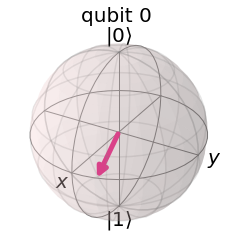

In [71]:
## creating a random 1-qubit state
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

***Let's create our initialization instruction to create |ψ⟩ from the state |0⟩:***

In [72]:
init_gate = Initialize(psi)
init_gate.label = "init"

***(Initialize is technically not a gate since it contains a reset operation, and so is not reversible. We call it an 'instruction' instead). If the quantum teleportation circuit works, then at the end of the circuit the qubit |q2⟩ will be in this state. We will check this using the statevector simulator***

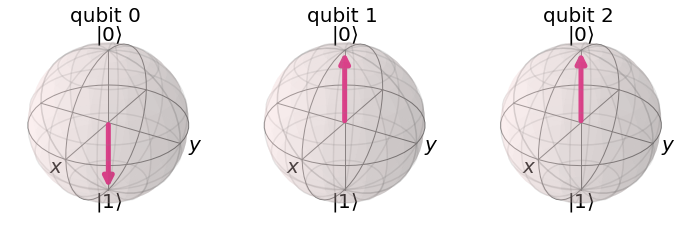

In [73]:
sim = Aer.get_backend("aer_simulator")
teleportation_circuit.save_statevector()
out_vector = sim.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

## test - 2

<IPython.core.display.Latex object>

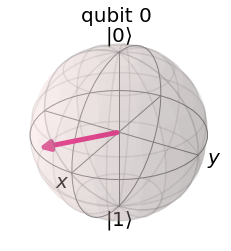

In [74]:
phi = random_statevector(2)
display(array_to_latex(phi, prefix="|\\phi\\rangle="))
plot_bloch_multivector(phi)

In [75]:
init_gate = Initialize(phi)
init_gate.label = "init"

In [76]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [77]:
##setup
#protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3,name="q")            ##protocol uses 3 qubits
crz = ClassicalRegister(1 , name = "crz")  ##and 2 classical bits in 2 different register
crx = ClassicalRegister(1, name = "crx")
teleportation_circuit = QuantumCircuit(qr,crz, crx)

## step 0
## first initalize alices q0
teleportation_circuit.append(init_gate,[0])
teleportation_circuit.barrier()

## step 1
## now begins the teleportation protocol

create_bell_pair(teleportation_circuit,1,2)
teleportation_circuit.barrier()

## step 2
## send q1 to Alice and q2 to Bob

alice_gates(teleportation_circuit,0,1)

## step 3
## Alice then sends her classical bits to Bob
measure_and_send(teleportation_circuit,0,1)

## step 4
## Bob decodes qubits
bob_gates(teleportation_circuit,2,crz,crx)

## step 5
## reverse the initializing process
#teleportation_circuit.append(inverse_init_gate,[2])

##display the circuit
teleportation_circuit.draw()

┌─────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
  q_0: ┤ init(0.51285+0.29663j,0.63292-0.49841j) ├─░────────────░───■──┤ H ├─░─»
       └─────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
  q_1: ────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
  q_2: ────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
crz: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
crx: 1/════════════════════════════════════════════════════════════════════════»
                                                                               »
«       ┌─┐                 
«  q_0: ┤M├─────────────────
«       └╥┘┌─┐              
«  q_1: ─╫─┤M├──────────────
«        ║ └╥┘ ┌───┐  ┌───┐ 
«  q_2: ─╫──╫──┤ X ├──┤ Z ├─
«        ║  ║  └─╥─┘  └─╥─┘ 
«        ║  ║    ║   ┌──╨──┐
«crz: 1/═╩══╬════╬═══╡ 0x1 ╞
«        0  ║ ┌──╨──┐└─────┘
«crx: 1/════╩═╡ 0x1 ╞═══════
«           0 └─────┘

In [78]:
## need to add a new classical register
## to see the result
#cr_result = ClassicalRegister(1)
#teleportation_circuit.add_register(cr_result)
#teleportation_circuit.measure(2,2)
#teleportation_circuit.draw()

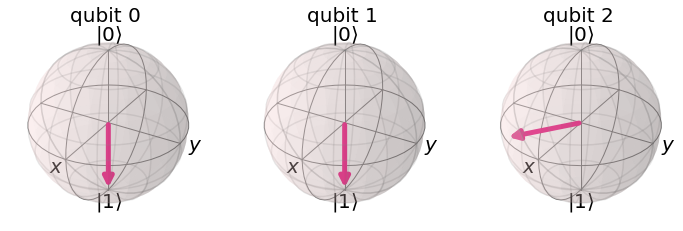

In [79]:
tsim = Aer.get_backend("aer_simulator")
teleportation_circuit.save_statevector()
rcv_statevector = tsim.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(rcv_statevector)

In [80]:
#t_qc = transpile(teleportation_circuit,tsim)
#t_qc.save_statevector()
#counts = tsim.run(t_qc).result().get_counts()
#qubit_counts = [marginal_counts(counts,[qubit]) for qubit in range (3)]
#plot_histogram(qubit_counts)

## so the quantum teleportation algorithm is working properly